<a href="https://colab.research.google.com/github/fedassembly/tensorflow-cert-prep/blob/main/08_Introduction_to_NLP_(Natural_Language_Processing)_in_TensorFlow_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
!unzip nlp_getting_started.zip

--2023-10-08 11:51:56--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2023-10-08 11:51:56 (96.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]

Archive:  nlp_getting_started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) instead of the Functional API.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [3]:
tweets_data = pd.read_csv("train.csv")
tweets_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
X = tweets_data["text"].to_numpy()
y = tweets_data["target"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6851,), (762,), (6851,), (762,))

In [5]:
import time

class Timer:
    def __init__(self):
        self._start_time = None
        self._elapsed_time = None

    def start(self):
        """Start a new timer"""
        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        self._elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {self._elapsed_time:0.4f} seconds")

t = Timer()

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
    ])
model_0.name = "model_0"

t.start()
_ = model_0.fit(X_train, y_train)
t.stop()
model_0.fit_time = t._elapsed_time

Elapsed time: 0.3179 seconds


In [7]:
def model_results(model, X, y):
  y_pred = model.predict(X)
  if y_pred.dtype != "int64":
    y_pred = np.squeeze(np.round(y_pred)).astype("int64")
  clf_rpt = classification_report(y_test, y_pred, output_dict=True)
  model_results = {
      "accuracy": clf_rpt["accuracy"],
      "precision": clf_rpt["weighted avg"]["precision"],
      "recall": clf_rpt["weighted avg"]["recall"],
      "f1-score": clf_rpt["weighted avg"]["f1-score"],
      "fit_time": model.fit_time
  }
  return model_results

In [8]:
model_0_results = model_results(model_0, X_test, y_test)
model_0_results

{'accuracy': 0.7782152230971129,
 'precision': 0.792992256322435,
 'recall': 0.7782152230971129,
 'f1-score': 0.7703527809038113,
 'fit_time': 0.31793458500000327}

In [9]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = int(np.ceil(np.array([len(t.split()) for t in X_train]).max()))

int_vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    name="text_vectorizer"
    )

int_vectorize_layer.adapt(X_train)

model_1 = tf.keras.Sequential([
    int_vectorize_layer,
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, 128, mask_zero=True, name="embeddings"),
    # If mask_zero is set to True, as a consequence, index 0 cannot be used
    # in the vocabulary (input_dim should equal size of vocabulary + 1).
    tf.keras.layers.GlobalAveragePooling1D(name="global_avg_pooling"),
    tf.keras.layers.Dense(1, activation="sigmoid", name="probs")
  ], name="model_1"
  )

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorizer (TextVecto  (None, 31)                0         
 rization)                                                       
                                                                 
 embeddings (Embedding)      (None, 31, 128)           1280128   
                                                                 
 global_avg_pooling (Global  (None, 128)               0         
 AveragePooling1D)                                               
                                                                 
 probs (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280257 (4.88 MB)
Trainable params: 1280257 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
model_1.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
    )

In [11]:
t.start()
history_1 = model_1.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=5
    )
t.stop()
model_1.fit_time = t._elapsed_time

Epoch 1/5
215/215 [==============================] - 32s 112ms/step - loss: 0.6015 - accuracy: 0.7165 - val_loss: 0.5229 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.4179 - accuracy: 0.8323 - val_loss: 0.4838 - val_accuracy: 0.7927
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3258 - accuracy: 0.8717 - val_loss: 0.4917 - val_accuracy: 0.7966
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2636 - accuracy: 0.9021 - val_loss: 0.5136 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2172 - accuracy: 0.9193 - val_loss: 0.5425 - val_accuracy: 0.7677
Elapsed time: 83.3265 seconds


In [12]:
model_1_results = model_results(model_1, X_test, y_test)
model_1_results

24/24 [==============================] - 0s 2ms/step


{'accuracy': 0.7677165354330708,
 'precision': 0.7675702737292196,
 'recall': 0.7677165354330708,
 'f1-score': 0.7657830172803203,
 'fit_time': 83.32652255100001}

Is it better to use TFDS?

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32)

int_vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    name="text_vectorizer"
    )

train_text = train_ds.map(lambda text, labels: text)
int_vectorize_layer.adapt(train_text)

def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

train_ds = train_ds.map(int_vectorize_text)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(int_vectorize_text)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1,
                              128,
                              input_length=MAX_SEQUENCE_LENGTH,
                              mask_zero=True,
                              name="embeddings"),
    tf.keras.layers.GlobalAveragePooling1D(name="global_avg_pooling"),
    tf.keras.layers.Dense(1, activation="sigmoid", name="probs")
], name="model_1"
)

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 31, 128)           1280128   
                                                                 
 global_avg_pooling (Global  (None, 128)               0         
 AveragePooling1D)                                               
                                                                 
 probs (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280257 (4.88 MB)
Trainable params: 1280257 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model_1.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
    )

In [16]:
t.start()
history_1 = model_1.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)
t.stop()
model_1.fit_time = t._elapsed_time

Epoch 1/5
215/215 [==============================] - 20s 90ms/step - loss: 0.6027 - accuracy: 0.7087 - val_loss: 0.5218 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4200 - accuracy: 0.8314 - val_loss: 0.4786 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3263 - accuracy: 0.8717 - val_loss: 0.4863 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2638 - accuracy: 0.8993 - val_loss: 0.5100 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2167 - accuracy: 0.9218 - val_loss: 0.5424 - val_accuracy: 0.7782
Elapsed time: 25.3252 seconds


In [17]:
model_1_results = model_results(model_1, test_ds, y_test)
model_1_results

24/24 [==============================] - 0s 1ms/step


{'accuracy': 0.7782152230971129,
 'precision': 0.7780255870268207,
 'recall': 0.7782152230971129,
 'f1-score': 0.7766233565516653,
 'fit_time': 25.325229527999994}

In [18]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1,
                              128,
                              input_length=MAX_SEQUENCE_LENGTH,
                              mask_zero=True,
                              name="embeddings"),
    tf.keras.layers.LSTM(64, name="lstm"),
    tf.keras.layers.Dense(1, activation="sigmoid", name="probs")
], name="model_2"
)

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 31, 128)           1280128   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 probs (Dense)               (None, 1)                 65        
                                                                 
Total params: 1329601 (5.07 MB)
Trainable params: 1329601 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model_2.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
    )
t.start()
history_2 = model_2.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)
t.stop()
model_2.fit_time = t._elapsed_time

Epoch 1/5
215/215 [==============================] - 23s 78ms/step - loss: 0.5111 - accuracy: 0.7522 - val_loss: 0.4543 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3031 - accuracy: 0.8799 - val_loss: 0.5539 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1949 - accuracy: 0.9308 - val_loss: 0.7625 - val_accuracy: 0.7323
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1342 - accuracy: 0.9534 - val_loss: 1.0147 - val_accuracy: 0.7480
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0990 - accuracy: 0.9641 - val_loss: 0.9108 - val_accuracy: 0.7533
Elapsed time: 33.1677 seconds


In [20]:
model_2_results = model_results(model_2, test_ds, y_test)
model_2_results

24/24 [==============================] - 2s 3ms/step


{'accuracy': 0.7532808398950132,
 'precision': 0.7538544133032322,
 'recall': 0.7532808398950132,
 'f1-score': 0.750202589132622,
 'fit_time': 33.16770535500001}

In [21]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE + 1,
                              128,
                              input_length=MAX_SEQUENCE_LENGTH,
                              mask_zero=True,
                              name="embeddings"),
    tf.keras.layers.Convolution1D(64, 5, activation="relu", name="conv"),
    tf.keras.layers.GlobalMaxPooling1D(name="global_max_pooling"),
    tf.keras.layers.Dense(1, activation="sigmoid", name="probs")
], name="model_5"
)

model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 31, 128)           1280128   
                                                                 
 conv (Conv1D)               (None, 27, 64)            41024     
                                                                 
 global_max_pooling (Global  (None, 64)                0         
 MaxPooling1D)                                                   
                                                                 
 probs (Dense)               (None, 1)                 65        
                                                                 
Total params: 1321217 (5.04 MB)
Trainable params: 1321217 (5.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model_5.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
    )
t.start()
history_5 = model_5.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)
t.stop()
model_5.fit_time = t._elapsed_time

Epoch 1/5
215/215 [==============================] - 21s 71ms/step - loss: 0.5476 - accuracy: 0.7250 - val_loss: 0.4705 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3188 - accuracy: 0.8723 - val_loss: 0.5157 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1969 - accuracy: 0.9279 - val_loss: 0.5956 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1242 - accuracy: 0.9550 - val_loss: 0.6734 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0880 - accuracy: 0.9696 - val_loss: 0.7267 - val_accuracy: 0.7730
Elapsed time: 25.7169 seconds


In [23]:
model_5_results = model_results(model_5, test_ds, y_test)
model_5_results

24/24 [==============================] - 0s 2ms/step


{'accuracy': 0.7729658792650919,
 'precision': 0.7734418239236065,
 'recall': 0.7729658792650919,
 'f1-score': 0.7706594637674358,
 'fit_time': 25.716944058000024}

In [24]:
pd.DataFrame([
    model_0_results,
    model_1_results,
    model_2_results,
    model_5_results],
    index=[0, 1, 2, 5]
)

,accuracy,precision,recall,f1-score,fit_time
0,0.778215,0.792992,0.778215,0.770353,0.317935
1,0.778215,0.778026,0.778215,0.776623,25.325230
2,0.753281,0.753854,0.753281,0.750203,33.167705
5,0.772966,0.773442,0.772966,0.770659,25.716944



2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?

In [25]:
tweets_data_10 = tweets_data.sample(frac=0.1)

X = tweets_data_10["text"].to_numpy()
y = tweets_data_10["target"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((684,), (77,), (684,), (77,))

In [26]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
    ])
model_0.name = "model_0"

t.start()
_ = model_0.fit(X_train, y_train)
t.stop()
model_0.fit_time = t._elapsed_time

Elapsed time: 0.0314 seconds


In [27]:
model_0_results = model_results(model_0, X_test, y_test)
model_0_results

{'accuracy': 0.7532467532467533,
 'precision': 0.7508270031854938,
 'recall': 0.7532467532467533,
 'f1-score': 0.7519038784344906,
 'fit_time': 0.031437917999994625}

In [28]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
import tensorflow_hub as hub

model_6 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   input_shape=[],
                   dtype=tf.string,
                   trainable=False,
                   name="use"),
    tf.keras.layers.Dense(1, activation="sigmoid", name="probs")
], name="model_6"
)

model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 use (KerasLayer)            (None, 512)               256797824 
                                                                 
 probs (Dense)               (None, 1)                 513       
                                                                 
Total params: 256798337 (979.61 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [30]:
model_6.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
    )
t.start()
history_6 = model_6.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)
t.stop()
model_6.fit_time = t._elapsed_time

Epoch 1/5
22/22 [==============================] - 4s 34ms/step - loss: 0.6898 - accuracy: 0.5512 - val_loss: 0.6878 - val_accuracy: 0.5325
Epoch 2/5
22/22 [==============================] - 0s 13ms/step - loss: 0.6761 - accuracy: 0.7032 - val_loss: 0.6781 - val_accuracy: 0.6623
Epoch 3/5
22/22 [==============================] - 0s 12ms/step - loss: 0.6634 - accuracy: 0.7602 - val_loss: 0.6690 - val_accuracy: 0.7143
Epoch 4/5
22/22 [==============================] - 0s 14ms/step - loss: 0.6514 - accuracy: 0.7822 - val_loss: 0.6603 - val_accuracy: 0.7273
Epoch 5/5
22/22 [==============================] - 0s 14ms/step - loss: 0.6400 - accuracy: 0.7895 - val_loss: 0.6521 - val_accuracy: 0.7532
Elapsed time: 6.0038 seconds


In [31]:
model_6_results = model_results(model_6, X_test, y_test)
model_6_results

3/3 [==============================] - 0s 11ms/step


{'accuracy': 0.7532467532467533,
 'precision': 0.7780573593073593,
 'recall': 0.7532467532467533,
 'f1-score': 0.7594948007319141,
 'fit_time': 6.003771601999972}


3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting `training=True` when instantiating it as a Keras layer.

```
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```

In [32]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

model_6 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   input_shape=[],
                   dtype=tf.string,
                   trainable=True,
                   name="use"),
    tf.keras.layers.Dense(1, name="logits"),
    tf.keras.layers.Activation("sigmoid", dtype=tf.float32, name="probs")
], name="model_6"
)

model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 use (KerasLayer)            (None, 512)               256797824 
                                                                 
 logits (Dense)              (None, 1)                 513       
                                                                 
 probs (Activation)          (None, 1)                 0         
                                                                 
Total params: 256798337 (979.61 MB)
Trainable params: 256798337 (979.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
for layer in model_6.layers:
  print(layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

use string True <Policy "string">
logits float32 True <Policy "mixed_float16">
probs float32 True <Policy "float32">


In [34]:
model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"]
    )
t.start()
history_6 = model_6.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)
t.stop()
model_6.fit_time = t._elapsed_time

Epoch 1/5
22/22 [==============================] - 90s 3s/step - loss: 0.6826 - accuracy: 0.5819 - val_loss: 0.6660 - val_accuracy: 0.6494
Epoch 2/5
22/22 [==============================] - 2s 89ms/step - loss: 0.6585 - accuracy: 0.6111 - val_loss: 0.6437 - val_accuracy: 0.6623
Epoch 3/5
22/22 [==============================] - 2s 88ms/step - loss: 0.6357 - accuracy: 0.7135 - val_loss: 0.6287 - val_accuracy: 0.7532
Epoch 4/5
22/22 [==============================] - 2s 98ms/step - loss: 0.6091 - accuracy: 0.7763 - val_loss: 0.6123 - val_accuracy: 0.7532
Epoch 5/5
22/22 [==============================] - 2s 100ms/step - loss: 0.5788 - accuracy: 0.8099 - val_loss: 0.5940 - val_accuracy: 0.7532
Elapsed time: 98.5144 seconds



4. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the `sample_submission.csv` file from Kaggle (see the Files tab in Colab for what the `sample_submission.csv` file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?

In [35]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
submissions_data = pd.read_csv("sample_submission.csv")

X_train = train_data["text"].to_numpy()
y_train = train_data["target"].to_numpy()
X_test = test_data["text"].to_numpy()

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test,))
test_ds = test_ds.batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
import tensorflow_hub as hub

model_6 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   input_shape=[],
                   dtype=tf.string,
                   name="use"),
    tf.keras.layers.Dense(1, activation="sigmoid", name="probs")
], name="model_6"
)
model_6.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
    )
_ = model_6.fit(train_ds, epochs=5)

Epoch 1/5
238/238 [==============================] - 6s 16ms/step - loss: 0.6596 - accuracy: 0.7089
Epoch 2/5
238/238 [==============================] - 3s 12ms/step - loss: 0.6033 - accuracy: 0.7756
Epoch 3/5
238/238 [==============================] - 3s 12ms/step - loss: 0.5638 - accuracy: 0.7862
Epoch 4/5
238/238 [==============================] - 3s 12ms/step - loss: 0.5353 - accuracy: 0.7898
Epoch 5/5
238/238 [==============================] - 4s 16ms/step - loss: 0.5142 - accuracy: 0.7930


In [37]:
y_pred = model_6.predict(test_ds)
y_pred = np.squeeze(np.round(y_pred)).astype("int64")
submissions_data["target"] = y_pred

102/102 [==============================] - 1s 10ms/step


In [38]:
submissions_data.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1



5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?

In [39]:
X = tweets_data["text"].to_numpy()
y = tweets_data["target"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32)

int_vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    name="text_vectorizer"
    )

train_text = train_ds.map(lambda text, labels: text)
int_vectorize_layer.adapt(train_text)

def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

train_ds = train_ds.map(int_vectorize_text)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(int_vectorize_text)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
proba_0 = model_0.predict_proba(X_test)[:,1]
proba_1 = np.squeeze(model_1.predict(test_ds))
proba_2 = np.squeeze(model_2.predict(test_ds))
proba_5 = np.squeeze(model_5.predict(test_ds))

proba_ensemble = np.c_[proba_0, proba_1, proba_2, proba_5].mean(axis=1)

24/24 [==============================] - 0s 2ms/step


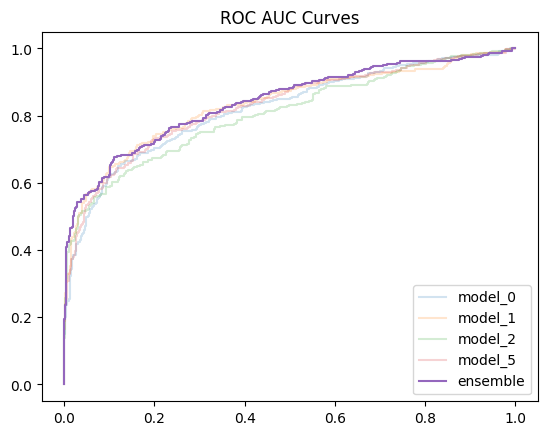

In [41]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

for mod_label, y_probs in zip(
    ["model_0", "model_1", "model_2", "model_5"],
     [proba_0, proba_1, proba_2, proba_5]):
  fpr, tpr, _ = roc_curve(y_test, y_probs)
  plt.plot(fpr, tpr, label=mod_label, alpha=0.2)
fpr, tpr, _ = roc_curve(y_test, proba_ensemble)
plt.plot(fpr, tpr, label="ensemble")
plt.legend(loc="lower right")
plt.title("ROC AUC Curves")
plt.show()

In [42]:
from scipy import stats

pred_0 = model_0.predict(X_test)
pred_1 = np.round(proba_1).astype("int64")
pred_2 = np.round(proba_2).astype("int64")
pred_5 = np.round(proba_5).astype("int64")

pred_ensemble, _ = stats.mode(np.c_[pred_0, pred_1, pred_2, pred_5], axis=1, keepdims=False)

              precision    recall  f1-score   support

           0       0.76      0.90      0.82       426
           1       0.83      0.64      0.72       336

    accuracy                           0.78       762
   macro avg       0.80      0.77      0.77       762
weighted avg       0.79      0.78      0.78       762



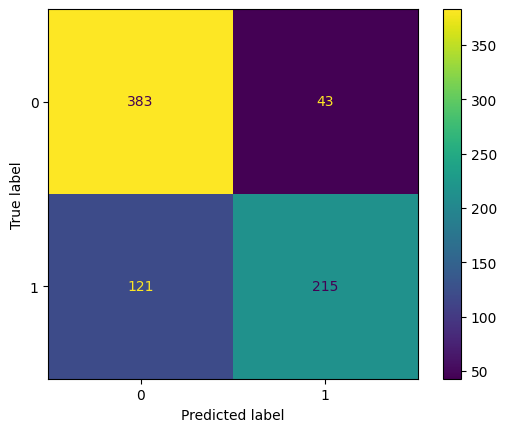

In [43]:
_ = ConfusionMatrixDisplay.from_predictions(y_test, pred_ensemble)
print(classification_report(y_test, pred_ensemble))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82       426
           1       0.81      0.68      0.74       336

    accuracy                           0.79       762
   macro avg       0.79      0.78      0.78       762
weighted avg       0.79      0.79      0.79       762



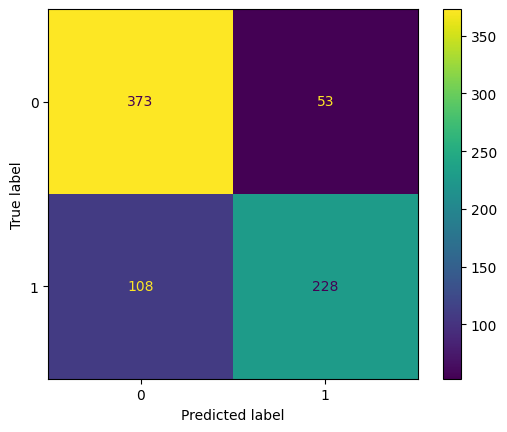

In [44]:
_ = ConfusionMatrixDisplay.from_predictions(y_test,
                                            np.round(proba_ensemble).astype("int64"))
print(classification_report(y_test, np.round(proba_ensemble).astype("int64")))